### Libraries

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from dateutil import parser
from datetime import datetime
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import string
import unidecode
import warnings
warnings.filterwarnings('ignore')


### Datasets

In [251]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_x.csv')

### Functions

In [252]:
def analyze_dataframe(df):
    """
    Function to analyze a DataFrame by printing:
    - Shape of the DataFrame
    - Information about each column (non-null count and data type)
    - Descriptive statistics for numerical columns
    - Number of missing values in each column
    - List of all column names

    Parameters:
    df (pd.DataFrame): The DataFrame to analyze
    """
    # Print shape of the DataFrame
    print("SHAPE")
    print(df.shape)
    print("\n----------------------------------------------------\n")
    
    # Print column information (non-null count, data types)
    print(df.info())
    print("\n----------------------------------------------------\n")
    
    # Print descriptive statistics for numerical columns
    print(df.describe())
    print("\n----------------------------------------------------\n")
    
    # Print count of missing values in each column
    print(df.isna().sum())
    print("\n----------------------------------------------------\n")
    
    # Print all column names
    print(df.columns)

In [253]:
def analyze_column(df, column_name):
    """
    Function to analyze a column in a DataFrame by printing:
    - Unique values
    - Value counts (including NaNs)
    - Number of missing values (NaNs)

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column
    column_name (str): The name of the column to analyze
    """
    # Print unique values
    print(f"Unique values in '{column_name}':")
    print(df[column_name].unique())
    print(' ')
    
    # Print value counts (including NaNs)
    print(f"Value counts in '{column_name}' (including NaNs):")
    print(df[column_name].value_counts(dropna=False))
    print(' ')
    
    # Print the number of missing values (NaNs)
    print(f"Number of missing values (NaNs) in '{column_name}':")
    print(df[column_name].isna().sum())
    
    print(' ')
    print(df[column_name].describe())

In [254]:
def find_categorical_columns(df):
    cat_columns=[]
    for col in df.columns:
        if df[col].dtypes=="O":
            cat_columns.append(col)
    return cat_columns

In [255]:
def turkish_lowercase(text):
    replacements = {
        'İ': 'i',
        'I': 'ı',
        'Ş': 'ş',
        'Ç': 'ç',
        'Ğ': 'ğ',
        'Ö': 'ö',
        'Ü': 'ü',
        'ı': 'ı',
        'ş': 'ş',
        'ç': 'ç',
        'ğ': 'ğ',
        'ö': 'ö',
        'ü': 'ü'
    }
    return ''.join(replacements.get(char, char) for char in text).lower()

In [256]:
def turn_into_lower(columns, df):
    for i in columns:
        df[i] = df[i].fillna("-")
        df[i] = df[i].apply(turkish_lowercase)

In [257]:
def convert_to_datetime(df):
    formats = {  
        2016: '%Y-%m-%d',
        2017: '%m/%d/%Y',
        2018: '%d/%m/%Y',
        2019: '%d/%m/%Y',
        2020: '%m/%d/%y %H:%M',
        2021: '%m/%d/%y %H:%M',
        2022: '%d.%m.%Y %H:%M',
        2023: '%d.%m.%Y %H:%M'
    }

    for year, date_format in formats.items():
        mask = df['Basvuru Yili'] == year
        df.loc[mask, 'Dogum Tarihi'] = pd.to_datetime(
            df.loc[mask, 'Dogum Tarihi'],
            format=date_format,
            errors='coerce'
        )
    return df

In [258]:
def extract_year(date_str):

    match = re.search(r'(\d{4})', str(date_str))
    if match:
        return int(match.group(1))
    return None

In [259]:
def extract_numbers(text):
    if isinstance(text, str):
        numbers = re.findall(r'\d+', text)
        return int(max(numbers, key=int)) if numbers else 0
    return 0

In [260]:
def standardize_value(value):
    if isinstance(value, str):
        value = value.replace(' ', '')  # Remove spaces
        value = value.replace('-', '-')  # Ensure hyphen consistency
        value = value.replace('vealtı', 've altı')  # Handle specific terms
        return value
    return value

In [261]:
def list_outlier_values(df, column_name):
    """
    Lists outlier values in a specified column of a DataFrame using the IQR method.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to check for outliers.

    Returns:
    list: A list of outlier values in the specified column.
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Determine the outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Detect outlier values
    outlier_values = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)][column_name].tolist()
    
    return outlier_values

In [262]:
def convert_to_il(dogum_yeri):
    
    if isinstance(dogum_yeri, str):
        dogum_yeri = dogum_yeri.lower().strip()
    else:
        return dogum_yeri

    if '/' in dogum_yeri or '-' in dogum_yeri or ' ' in dogum_yeri:
        parts = re.split(r'[\/\- ]+', dogum_yeri)
        if len(parts) >= 2:
            ilce, il = parts[0], parts[1]
            if ilce in ilce_il_mapping:
                return ilce_il_mapping[ilce]
            elif il in il_list:
                return il
            else:
                return dogum_yeri
        else:
            return dogum_yeri
    else:
        if dogum_yeri in il_list:
            return dogum_yeri
        else:
            if dogum_yeri in ilce_il_mapping:
                return ilce_il_mapping[dogum_yeri]
            else:
                return dogum_yeri

In [263]:
sehirler = [
    "Adana", "Adıyaman", "Afyonkarahisar", "Ağrı", "Aksaray", "Amasya", "Ankara", "Antalya",
    "Ardahan", "Artvin", "Aydın", "Balıkesir", "Bartın", "Batman", "Bayburt", "Bilecik", "Bingöl",
    "Bitlis", "Bolu", "Burdur", "Bursa", "Çanakkale", "Çankırı", "Çorum", "Denizli", "Diyarbakır",
    "Düzce", "Edirne", "Elazığ", "Erzincan", "Erzurum", "Eskişehir", "Gaziantep", "Giresun", "Gümüşhane",
    "Hakkari", "Hatay", "Iğdır", "Isparta", "İstanbul", "İzmir", "Kahramanmaraş", "Karabük", "Karaman",
    "Kars", "Kastamonu", "Kayseri", "Kilis", "Kırıkkale", "Kırklareli", "Kırşehir", "Kocaeli", "Konya",
    "Kütahya", "Malatya", "Manisa", "Mardin", "Mersin", "Muğla", "Muş", "Nevşehir", "Niğde", "Ordu",
    "Osmaniye", "Rize", "Sakarya", "Samsun", "Siirt", "Sinop", "Sivas", "Şanlıurfa", "Şırnak", "Tekirdağ",
    "Tokat", "Trabzon", "Tunceli", "Uşak", "Van", "Yalova", "Yozgat", "Zonguldak"
]

def temizle_sehir(sehir):
    if pd.isna(sehir):
        return None
    if isinstance(sehir, str):
        sehir = sehir.lower()
        sehir = sehir.strip()

        for il in sehirler:
            if il.lower() in sehir:
                return il
    return None

In [264]:
def clean_department_name(name):
    if isinstance(name, str): 
        name = name.lower()  # Küçük harfe çevir
        name = name.replace('ü', 'u')  # Türkçe karakterleri standartlaştır
        name = name.replace('ı', 'i')
        name = name.replace('i̇', 'i')
        name = name.replace('ş', 's')
        name = name.replace('ç', 'c')
        name = name.replace('ğ', 'g')
        name = name.replace('ö', 'o')
        name = name.replace(' ', '')  # Boşlukları kaldır
        name = re.sub(r'\d+', '', name)  # Sayıları kaldır
        name = name.replace('ingilizce', '')  # "ingilizce" kelimesini kaldır
        name = name.replace('ing', '') 
        name = name.replace('programı', '')  
        name = name.replace('çap', '')  
        name = name.replace('yandal', '') 
        name = name.replace('tam', '')  
        name = name.replace('burslu', '')  
        name = name.replace('çift anadal', '')  
        name = name.replace('bölüm', '')  
        name = name.replace('bölümü', '')  
        name = name.replace('bolum', '') 
        name = name.replace('öğrenciyim', '')  
        name = name.replace('cap', '')  
        name = name.replace('fakültesi', '') 
        name = name.replace('burs', '')  
        name = name.replace('ikinci', '') 
        name = name.replace('öğretim', '')  
        name = name.replace('fakülte', '')  
        
        name = name.translate(str.maketrans('', '', string.punctuation))  # Noktalama işaretlerini kaldır
    return name

In [265]:
def clean_lise_name(name):
    if isinstance(name, str): 
        name = name.lower()  # Küçük harfe çevir
        name = name.replace('ü', 'u')  # Türkçe karakterleri standartlaştır
        name = name.replace('ı', 'i')
        name = name.replace('i̇', 'i')
        name = name.replace('ş', 's')
        name = name.replace('ç', 'c')
        name = name.replace('ğ', 'g')
        name = name.replace('ö', 'o')
        name = name.replace(' ', '')  # Boşlukları kaldır
        name = re.sub(r'\d+', '', name)  # Sayıları kaldır
        
        name = name.translate(str.maketrans('', '', string.punctuation))  # Noktalama işaretlerini kaldır
    return name

In [266]:
def convert_to_int(value):
    try:
        return int(float(value))
    except ValueError:
        return value

In [267]:
def ingilizce_seviye_guncelle(row):
    if row['Ingilizce Biliyor musunuz?'] == 1 and pd.notna(row['Ingilizce Seviyeniz?']):
        return row['Ingilizce Seviyeniz?']
    return row['Ingilizce Biliyor musunuz?']

### Map

In [268]:
dgm_yeri_map = {
    "other" : "Other",
    "diger" : "Other",
    "diğer" : "Other"
}

In [269]:
ortalama_mapping = {'ORTALAMA BULUNMUYOR': 0, 
                   'Not ortalaması yok': 0, 
                   'Ortalama bulunmuyor': 0,
                   'Hazırlığım': 0,
                   '0 - 1.79': 0, 
                   '1.00 - 2.50':1, 
                   '1.80 - 2.49':1, 
                   '2.50 ve altı':1, 
                   '2.00 - 2.50':1, 
                   "3.00-2.50":2,
                   "2.50 - 3.00":2, 
                   "2.50 - 2.99":2, 
                   '2.50 -3.00':2, 
                   '3.00 - 3.50':3, 
                   '3.50-3':3, 
                   '3.00 - 3.49':3, 
                   '3.00 - 4.00':3, 
                   '3.50 - 4.00':4, 
                   '4-3.5':4,
                   '4.0-3.5':4
}

In [270]:
uni_sinif = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    'tez': 7,
    'yüksek lisans': 7,
    'mezun': 0,
    'hazırlık': 0,
    '0': 0
}

In [271]:
test_ort_map = {
    'Hazırlığım': 0,
    '0 - 1.79': 0,
    '1.80 - 2.49': 1,
    '2.50 - 2.99': 2,
    '3.00 - 3.49': 3,
    '3.50 - 4.00':4,
}

In [272]:
lise_turu = {
    'imam hatip lisesi': 0,
    'diğer': 0,
    'devlet': 0,
    'düz lise': 0,
    'meslek lisesi': 1,
    'meslek': 1,
    'özel': 2,
    'özel lisesi': 2,
    'anadolu lisesi': 3,
    'fen lisesi': 4
}

In [273]:
lise_bolumu_mapping = {
    # Sayısal
    'Sayısal': 'Sayısal',
    'FEN SAYISAL BİLİMLERİ ALANI': 'Sayısal',
    'sayısal': 'Sayısal',
    'MF': 'Sayısal',
    'SAYISAL': 'Sayısal',
    'Fen Bilimleri': 'Sayısal',
    'Fen': 'Sayısal',
    'FEN BİLİMLERİ': 'Sayısal',
    'Matematik-Fen': 'Sayısal',
    'fen bilimleri': 'Sayısal',
    'fen': 'Sayısal',
    'mf': 'Sayısal',
    'Fen bilimleri': 'Sayısal',
    'Sayisal': 'Sayısal',
    'Fen-Matematik': 'Sayısal',
    'FEN': 'Sayısal',

    # Eşit Ağırlık
    'Eşit Ağırlık': 'Eşit Ağırlık',
    'EŞİT AĞIRLIK TÜRKÇE-MATEMATİK ALANI': 'Eşit Ağırlık',
    'eşit ağırlık': 'Eşit Ağırlık',
    'EŞİT AĞIRLIK': 'Eşit Ağırlık',
    'Türkçe-Matematik': 'Eşit Ağırlık',
    'tm': 'Eşit Ağırlık',
    'TM': 'Eşit Ağırlık',
    'Türkçe Matematik': 'Eşit Ağırlık',
    'TÜRKÇE-MATEMATİK': 'Eşit Ağırlık',
    'türkçe-matematik': 'Eşit Ağırlık',
    'türkçe matematik': 'Eşit Ağırlık',
    'Türkçe - Matematik': 'Eşit Ağırlık',
    'TÜRKÇE MATEMATİK': 'Eşit Ağırlık',
     'EA': 'Eşit Ağırlık',

    # Sözel
    'Sözel': 'Sözel',
    'sözel': 'Sözel',
    'SOSYAL ALANI': 'Sözel',
    'Sosyal Bilimler': 'Sözel',

    # Dil
    'Dil': 'Dil',
    'Yabancı Dil': 'Dil',
    'DİL ALANI': 'Dil',
    'yabancı dil': 'Dil',

    # Other (remaining categories)
    'Diğer': 'Other',
    '-': 'Other',
    'yok': 'Other',
    'Bilgisayar': 'Other',
    'Bilişim Teknolojileri': 'Other',
    'bilişim teknolojileri': 'Other',
    'BİLİŞİM TEKNOLOJİLERİ': 'Other',
    'Bilgisayarlı Muhasebe': 'Other',
}

In [274]:
lise_not_mapping = {
    # Highest Scores
    '75 - 100': 5,
    '100-85': 5,
    '4.00-3.50': 5,
    
    # High Scores
    '84-70': 4,
    '3.00 - 4.00': 4,
    '3.50-3.00': 4,
    '3.50-3': 4,
    
    # Mid Scores
    '50 - 75': 3,
    '69-55': 3,
    '3.00-2.50': 3,
    '50 - 74': 3,
    
    # Low Scores
    '2.50 ve altı': 2,
    '54-45': 2,
    '25 - 50': 1,
    
    # No Scores
    'Not ortalaması yok': 0,
    '44-0': 0,
    '0 - 25': 0,
    '25 - 49': 1,
    '0 - 24': 0
}

In [275]:
egitim_mapping = {
    "İlkokul": 1,
    "İLKOKUL MEZUNU": 1,
    "İlkokul Mezunu": 1,
    "Üniversite": 4,
    "ÜNİVERSİTE": 4,
    "Lise": 3,
    "LİSE": 3,
    "Ortaokul": 2,
    "ORTAOKUL MEZUNU": 2,
    "Ortaokul Mezunu": 2,
    "Lise Mezunu": 3,
    "Üniversite Mezunu": 4,
    "Yüksek Lisans": 5,
    "YÜKSEK LİSANS": 5,
    "Yüksek Lisans / Doktora": 5,
    "Doktora": 6,
    "Yüksek Lisans / Doktara":5,
    "DOKTORA": 6,
    "Eğitim Yok": 0,
    "EĞİTİM YOK": 0,
    "Eğitimi yok": 0
}

In [276]:
anne_calisma_map = {
    'emekli': 'hayır',
    '-': 'hayır', 
    'hayır': 'hayır',
    'evet': 'evet'
}

In [277]:
baba_egitim = {
    'eğitim yok': 0,
    'eğitimi yok': 0,
    '-': 0,
    '0':0,
    'ilkokul mezunu': 1,
    'ilkokul': 1,
    'ortaokul mezunu': 2,
    'ortaokul': 2,
    'lise': 3,
    'üniversite': 4,
    'yüksek lisans': 5,
    'yüksek lisans / doktora': 5,
    'doktora': 5
}

In [278]:
spor_rol_mapping = {
    '-': 0,
    '0': 0,
    'diğer': 1,
    'bireysel': 2,
    'takım oyuncusu': 3,
    'lider/kaptan': 4,
    'kaptan / lider': 4,
    'kaptan': 4
}

In [279]:
spor_rolt_mapping = {
    '-': 0,
    'diğer': 1,
    'bireysel spor': 2,
    'takım oyuncusu': 3,
    'lider/kaptan': 4,
}

In [280]:
binary_map = {
    'Hayır': 0,
    'Evet': 1
}

binary_lower ={
    'hayır': 0,
    'evet': 1
}

In [281]:
ing_map = {
    '0': 0,
    'Başlangıç': 1,
    'Orta': 2,
    'İleri': 3
}

### Null Check

In [282]:
null_perc = train_df.isnull().sum() / len(train_df)
null_perc_70 = null_perc[null_perc > 0.70]
null_perc.sort_values(ascending = False, inplace = True)

null_perc_t = test_df.isnull().sum() / len(test_df)
null_perc_70_t = null_perc_t[null_perc_t > 0.70]
null_perc_t.sort_values(ascending = False, inplace = True)

In [283]:
null_perc_70

Lise Adi Diger                                               0.927324
Lise Bolum Diger                                             0.976568
Uye Oldugunuz Kulubun Ismi                                   0.747655
Hangi STK'nin Uyesisiniz?                                    0.760353
Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?    0.775831
Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite        0.993566
dtype: float64

### Finding categorical columns

In [284]:
categorical_cols = find_categorical_columns(train_df)
categorical_cols

['Cinsiyet',
 'Dogum Tarihi',
 'Dogum Yeri',
 'Ikametgah Sehri',
 'Universite Adi',
 'Universite Turu',
 'Burs Aliyor mu?',
 'Bölüm',
 'Universite Kacinci Sinif',
 'Universite Not Ortalamasi',
 'Daha Once Baska Bir Universiteden Mezun Olmus',
 'Lise Adi',
 'Lise Adi Diger',
 'Lise Sehir',
 'Lise Turu',
 'Lise Bolumu',
 'Lise Bolum Diger',
 'Lise Mezuniyet Notu',
 'Baska Bir Kurumdan Burs Aliyor mu?',
 'Burs Aldigi Baska Kurum',
 'Baska Kurumdan Aldigi Burs Miktari',
 'Anne Egitim Durumu',
 'Anne Calisma Durumu',
 'Anne Sektor',
 'Baba Egitim Durumu',
 'Baba Calisma Durumu',
 'Baba Sektor',
 'Kardes Sayisi',
 'Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?',
 'Uye Oldugunuz Kulubun Ismi',
 'Profesyonel Bir Spor Daliyla Mesgul musunuz?',
 'Spor Dalindaki Rolunuz Nedir?',
 'Aktif olarak bir STK üyesi misiniz?',
 "Hangi STK'nin Uyesisiniz?",
 'Stk Projesine Katildiniz Mi?',
 'Girisimcilikle Ilgili Deneyiminiz Var Mi?',
 'Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?',
 'I

In [285]:
columns_need_lower = ['Cinsiyet', 'Dogum Yeri', 'Universite Kacinci Sinif', 'Universite Turu', 
                      'Burs Aldigi Baska Kurum', 'Anne Calisma Durumu', 'Anne Sektor', 
                      'Baba Calisma Durumu', 'Baba Sektor', 'Spor Dalindaki Rolunuz Nedir?', 
                      'Dogum Yeri', 'Baba Egitim Durumu', 'Aktif olarak bir STK üyesi misiniz?',
                     'Girisimcilikle Ilgili Deneyiminiz Var Mi?'
                     ]

turn_into_lower(columns_need_lower, train_df)
turn_into_lower(columns_need_lower, test_df)

### 1-) Basvuru Yili

In [286]:
analyze_column(train_df, 'Basvuru Yili')

Unique values in 'Basvuru Yili':
[2014 2015 2016 2017 2018 2019 2020 2021 2022]
 
Value counts in 'Basvuru Yili' (including NaNs):
Basvuru Yili
2021    11594
2017    10325
2015     7804
2020     7760
2022     7622
2019     7248
2014     6454
2016     5213
2018     1105
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Basvuru Yili':
0
 
count    65125.000000
mean      2018.277298
std          2.669979
min       2014.000000
25%       2016.000000
50%       2019.000000
75%       2021.000000
max       2022.000000
Name: Basvuru Yili, dtype: float64


In [287]:
train_df['Basvuru Yili'] = train_df['Basvuru Yili'].astype('int')
test_df['Basvuru Yili'] = test_df['Basvuru Yili'].astype('int')

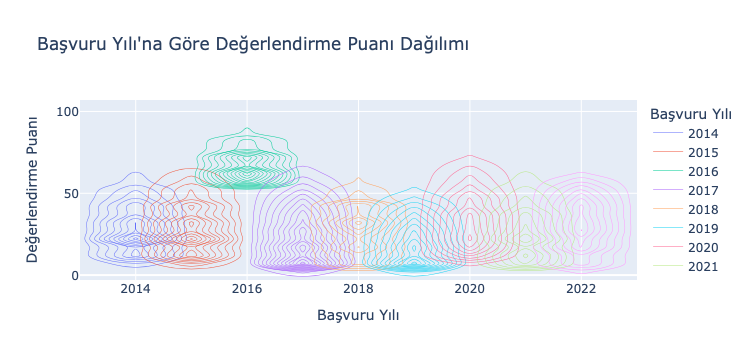

In [288]:
# Create a KDE plot with Plotly
fig = px.density_contour(
    train_df,
    x='Basvuru Yili',  # x-axis for year
    y='Degerlendirme Puani',  # y-axis for points
    color='Basvuru Yili',  # Color by year
    labels={'Basvuru Yili': 'Başvuru Yılı', 'Degerlendirme Puani': 'Değerlendirme Puanı'},
    title="Başvuru Yılı'na Göre Değerlendirme Puanı Dağılımı"
)

# Show the plot
fig.show()

In [289]:
values_to_drop=[2016]
indexes_to_drop = train_df[train_df['Basvuru Yili'].isin(values_to_drop)].index
train_df = train_df.drop(indexes_to_drop)

### 2-) Degerlendirme Puani

In [290]:
train_df['Degerlendirme Puani'] = train_df['Degerlendirme Puani'].fillna(train_df['Degerlendirme Puani'].median())
analyze_column(train_df, 'Degerlendirme Puani')

#test_df['Degerlendirme Puani'] -> yok

Unique values in 'Degerlendirme Puani':
[52. 30. 18. 40. 24. 37. 31. 28. 26. 58. 34. 33. 48. 10.  8. 54. 14. 44.
 60. 42. 22. 16. 29. 46. 41. 50. 53. 36. 32. 38. 20. 12. 51. 65. 56. 61.
 62. 49. 70. 43. 23. 64. 59. 57. 63. 71. 98. 21. 66. 27. 39. 68. 85. 45.
 67. 47. 78. 19. 13. 90. 72. 77. 55.  6. 79. 76. 75. 74. 73. 17.  7.  4.
 15. 35. 25.  5. 11.  9.  3. 80.  2.  1.  0. 69. 82. 81. 89. 84. 83. 95.]
 
Value counts in 'Degerlendirme Puani' (including NaNs):
Degerlendirme Puani
28.0    2064
22.0    2041
18.0    1995
24.0    1785
12.0    1740
        ... 
83.0       2
85.0       2
89.0       1
98.0       1
95.0       1
Name: count, Length: 90, dtype: int64
 
Number of missing values (NaNs) in 'Degerlendirme Puani':
0
 
count    59912.000000
mean        29.027490
std         15.294341
min          0.000000
25%         17.000000
50%         28.000000
75%         40.000000
max         98.000000
Name: Degerlendirme Puani, dtype: float64


### 3-) Cinsiyet

In [291]:
# train
train_df['Cinsiyet'] = train_df['Cinsiyet'].replace('-', 'erkek')
train_df = pd.get_dummies(train_df, columns = ['Cinsiyet'], prefix = 'Cinsiyet')

In [292]:
# test
test_df = pd.get_dummies(test_df, columns = ['Cinsiyet'], prefix = 'Cinsiyet')

### 4-) Dogum Tarihi

In [293]:
# train
train_df = convert_to_datetime(train_df)
train_df['Dogum Yili'] = train_df['Dogum Tarihi'].apply(extract_year)
train_df['Basvuru Yasi'] = train_df['Basvuru Yili'] - train_df['Dogum Yili']
train_df = train_df.drop(columns=['Dogum Tarihi', 'Dogum Yili'])
train_df['Basvuru Yasi'] = train_df['Basvuru Yasi'].fillna(train_df['Basvuru Yasi'].mean())

In [294]:
# test
test_df = convert_to_datetime(test_df)
test_df['Dogum Yili'] = test_df['Dogum Tarihi'].apply(extract_year)
test_df['Basvuru Yasi'] = test_df['Basvuru Yili'] - test_df['Dogum Yili']
test_df = test_df.drop(columns=['Dogum Tarihi', 'Dogum Yili'])

### 5-) Dogum Yeri (astype category)

In [295]:
df_il_ilce = pd.read_csv('il_ilce.csv')
df_il_ilce['il_lower'] = df_il_ilce['il'].str.lower()
df_il_ilce['ilce_lower'] = df_il_ilce['ilce'].str.lower()

ilce_il_mapping = dict(zip(df_il_ilce['ilce_lower'], df_il_ilce['il_lower']))

il_list = df_il_ilce['il_lower'].tolist()

In [296]:
# train
train_df['Dogum Yeri'] = train_df['Dogum Yeri'].str.lower()

train_df['Dogum Yeri'] = train_df['Dogum Yeri'].apply(convert_to_il)

train_df["Dogum Yeri"] = train_df["Dogum Yeri"].fillna("Other").str.lower()

threshold = 100
dogum_yeri_counts = train_df['Dogum Yeri'].value_counts()
train_df["Dogum Yeri"] = train_df["Dogum Yeri"].apply(lambda x: x if dogum_yeri_counts[x] >= threshold else 'Other')

train_df["Dogum Yeri"] = train_df["Dogum Yeri"].replace(dgm_yeri_map)

In [297]:
# test
test_df['Dogum Yeri'] = test_df['Dogum Yeri'].str.lower()

test_df['Dogum Yeri'] = test_df['Dogum Yeri'].apply(convert_to_il)

test_df["Dogum Yeri"] = test_df["Dogum Yeri"].fillna("Other").str.lower()

threshold = 100
dogum_yeri_counts = test_df['Dogum Yeri'].value_counts()
test_df["Dogum Yeri"] = test_df["Dogum Yeri"].apply(lambda x: x if dogum_yeri_counts[x] >= threshold else 'Other')

test_df["Dogum Yeri"] = test_df["Dogum Yeri"].replace(dgm_yeri_map)

### 6-) Ikametgah Sehri (astype catergory) 

In [298]:
# train
train_df['Ikametgah Sehri'] = train_df['Ikametgah Sehri'].apply(temizle_sehir)
train_df['Ikametgah Sehri'] = train_df['Ikametgah Sehri'].fillna('Diger')
analyze_column(train_df, 'Ikametgah Sehri')

Unique values in 'Ikametgah Sehri':
['Ankara' 'İstanbul' 'Kayseri' 'İzmir' 'Kahramanmaraş' 'Diger' 'Trabzon'
 'Kars' 'Kırşehir' 'Kocaeli' 'Ordu' 'Osmaniye' 'Antalya' 'Konya' 'Bartın'
 'Bingöl' 'Mersin' 'Bursa' 'Manisa' 'Samsun' 'Diyarbakır' 'Kırklareli'
 'Muğla' 'Zonguldak' 'Erzurum' 'Batman' 'Gaziantep' 'Aydın' 'Adana'
 'Balıkesir' 'Şanlıurfa' 'Sakarya' 'Niğde' 'Aksaray' 'Kütahya' 'Uşak'
 'Bolu' 'Kastamonu' 'Tekirdağ' 'Düzce' 'Sinop' 'Elazığ' 'Kırıkkale'
 'Isparta' 'Ağrı' 'Giresun' 'Hatay' 'Denizli' 'Çanakkale' 'Siirt' 'Sivas'
 'Malatya' 'Şırnak' 'Hakkari' 'Mardin' 'Van' 'Erzincan' 'Bayburt' 'Yozgat'
 'Çorum' 'Karabük' 'Bitlis' 'Amasya' 'Tunceli' 'Edirne' 'Ardahan' 'Tokat'
 'Yalova' 'Karaman' 'Burdur' 'Artvin' 'Eskişehir' 'Rize' 'Iğdır' 'Muş'
 'Adıyaman' 'Bilecik' 'Afyonkarahisar' 'Nevşehir' 'Gümüşhane' 'Çankırı'
 'Kilis']
 
Value counts in 'Ikametgah Sehri' (including NaNs):
Ikametgah Sehri
İstanbul    14640
Diger        8035
Ankara       5917
İzmir        2741
Bursa        1714
    

In [299]:
# test
test_df['Ikametgah Sehri'] = test_df['Ikametgah Sehri'].apply(temizle_sehir)
test_df['Ikametgah Sehri'] = test_df['Ikametgah Sehri'].fillna('Diger')
analyze_column(test_df, 'Ikametgah Sehri')

Unique values in 'Ikametgah Sehri':
['Amasya' 'Konya' 'İstanbul' 'Mardin' 'İzmir' 'Kırşehir' 'Adıyaman'
 'Bursa' 'Antalya' 'Ankara' 'Tekirdağ' 'Gaziantep' 'Kütahya' 'Hakkari'
 'Hatay' 'Tokat' 'Manisa' 'Osmaniye' 'Giresun' 'Muğla' 'Erzurum'
 'Kahramanmaraş' 'Batman' 'Kayseri' 'Çanakkale' 'Adana' 'Malatya' 'Sivas'
 'Şanlıurfa' 'Diyarbakır' 'Tunceli' 'Rize' 'Mersin' 'Bingöl' 'Siirt'
 'Aksaray' 'Şırnak' 'Elazığ' 'Van' 'Aydın' 'Ağrı' 'Muş' 'Çorum' 'Burdur'
 'Kocaeli' 'Balıkesir' 'Samsun' 'Uşak' 'Edirne' 'Ordu' 'Eskişehir'
 'Kastamonu' 'Karabük' 'Kars' 'Bitlis' 'Sakarya' 'Diger' 'Afyonkarahisar'
 'Zonguldak' 'Isparta' 'Trabzon' 'Niğde' 'Yalova' 'Artvin' 'Karaman'
 'Denizli' 'Bayburt' 'Erzincan' 'Bilecik' 'Çankırı' 'Kilis' 'Ardahan'
 'Nevşehir' 'Yozgat' 'Bolu' 'Düzce' 'Iğdır' 'Kırıkkale' 'Bartın'
 'Gümüşhane' 'Sinop' 'Kırklareli']
 
Value counts in 'Ikametgah Sehri' (including NaNs):
Ikametgah Sehri
İstanbul      3301
Ankara        1132
İzmir          509
Diyarbakır     327
Hatay          325

### 7-) Universite Adi

In [300]:
# train
most_common_dep = train_df['Universite Adi'].value_counts().head(150).index

train_df['Universite Adi'] = train_df['Universite Adi'].apply(lambda x: x if x in most_common_dep else "Other")
train_df['Universite Adi'] = le.fit_transform(train_df['Universite Adi'])
analyze_column(train_df, 'Universite Adi')

Unique values in 'Universite Adi':
[131  98 145 142 140  19  23 116 134 146 136 137  24  92  74  59  64  14
  91 135 101  78 109 125 138 117 130  65 129 112  57  37  58  26  96  95
   8  73  48  82   9   0 143 100 127  20  66  18 118  12  50  81 123  42
 102 106 141  38  72  22  93  31  52  69  39  88 126  68  83  46 108 111
  89  70 119  13   3 147  34  84 113  86  44   6  51  85 120  47  33   7
  43  56  99   1 104  49  32  80  35 139   2  67  36 115  60  28  54  63
  90 133   4  41  21  71  45 132 110  61  15 114 148 103 144  29 122  11
 107  77 124  10  79  53  76  25   5  94  27  87  30  40  97  17 149  75
 105 150  62 121  55 128  16]
 
Value counts in 'Universite Adi' (including NaNs):
Universite Adi
98     9923
143    2083
81     1672
141    1464
119    1438
       ... 
105      95
145      95
77       95
5        94
16       93
Name: count, Length: 151, dtype: int64
 
Number of missing values (NaNs) in 'Universite Adi':
0
 
count    59912.000000
mean        80.767876
std      

In [301]:
# test
test_common_dep = test_df['Universite Adi'].value_counts().head(150).index

test_df['Universite Adi'] = test_df['Universite Adi'].apply(lambda x: x if x in test_common_dep else "Other")
test_df['Universite Adi'] = le.fit_transform(test_df['Universite Adi'])
analyze_column(test_df, 'Universite Adi')

Unique values in 'Universite Adi':
[ 88  56  99  84  35 150  80 124  91  38  81  48 144  51 113  52  76  11
 128  77  39  41 108  73 126 109 114  94 129  82  89   5 132 143  97  54
 138 102  49  25 134   0 141  32  17 105  10  86  42  28 139  45  95  16
   3  53 133 145  67  23  72  59  22  14  40  26  21 107  85  68 106 101
  55  66  46 112 149  96  43  15  36  75  83 104  19 131 136 122  31   9
  69  70 118  92 100 116 147 115   6 148   7  61  50   2  37 110  74 137
 146  44  98 119  87  34  60   4 135 111  93  63 125  90  47 120  58  71
 103  33  30  62  78   8  57 117  20  65 130  13  64   1 121  27  29 127
 142 123 140  18  79  12  24]
 
Value counts in 'Universite Adi' (including NaNs):
Universite Adi
99     516
141    322
124    316
85     305
35     277
      ... 
148     20
121     20
1       19
63      19
29      18
Name: count, Length: 151, dtype: int64
 
Number of missing values (NaNs) in 'Universite Adi':
0
 
count    11049.000000
mean        79.251787
std         42.62158

### 8-) Universite Turu

In [302]:
# train
train_df['Universite Turu'] = train_df['Universite Turu'].replace('-', 'devlet')
train_df = pd.get_dummies(train_df, columns = ['Universite Turu'], prefix = 'Universite Turu')

In [303]:
# test
test_df = pd.get_dummies(test_df, columns = ['Universite Turu'], prefix = 'Universite Turu')

### 9-) Burslu ise Burs Yuzdesi (Drop test column bomboş)

In [304]:
# train
train_df['Burslu ise Burs Yuzdesi'] = train_df['Burslu ise Burs Yuzdesi'].fillna(0)
analyze_column(train_df, 'Burslu ise Burs Yuzdesi')

Unique values in 'Burslu ise Burs Yuzdesi':
[100.   99.   98.   91.5  90.   88.   87.5  85.   82.5  80.   75.   74.
  72.   70.   69.   67.5  67.   65.   64.   63.   62.5  62.   60.   57.5
  57.   55.   50.   49.   48.   46.   45.   41.5  41.   40.   37.   35.
  32.   30.   25.   20.   11.   10.    8.    7.    6.    5.    4.    3.
   2.    1.    0. ]
 
Value counts in 'Burslu ise Burs Yuzdesi' (including NaNs):
Burslu ise Burs Yuzdesi
0.0      50791
100.0     4502
50.0      2739
75.0       929
25.0       668
10.0        50
60.0        27
1.0         26
65.0        17
80.0        15
5.0         14
30.0        14
85.0        11
2.0         10
55.0         8
62.5         7
35.0         7
62.0         7
45.0         6
7.0          6
70.0         5
99.0         5
20.0         5
63.0         4
40.0         4
6.0          4
90.0         4
3.0          2
8.0          2
98.0         2
87.5         1
88.0         1
72.0         1
91.5         1
82.5         1
64.0         1
67.0         1
67.5  

In [305]:
# test
analyze_column(test_df, 'Burslu ise Burs Yuzdesi')

Unique values in 'Burslu ise Burs Yuzdesi':
[nan]
 
Value counts in 'Burslu ise Burs Yuzdesi' (including NaNs):
Burslu ise Burs Yuzdesi
NaN    11049
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Burslu ise Burs Yuzdesi':
11049
 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Burslu ise Burs Yuzdesi, dtype: float64


### 10-) Burs Aliyor mu? 

In [306]:
# train
train_df['Burs Aliyor mu?'] = train_df['Burs Aliyor mu?'].str.lower()
train_df = pd.get_dummies(train_df, columns = ['Burs Aliyor mu?'], prefix = 'Burs Aliyor mu?')

In [307]:
# test
test_df['Burs Aliyor mu?'] = test_df['Burs Aliyor mu?'].str.lower()
test_df = pd.get_dummies(test_df, columns = ['Burs Aliyor mu?'], prefix = 'Burs Aliyor mu?')

### 11-) Bölüm

In [308]:
# train
train_df['Bölüm'] = train_df['Bölüm'].fillna('Diger')
train_df['Bölüm'] = train_df['Bölüm'].apply(clean_department_name)
common_dep = train_df['Bölüm'].value_counts().head(50).index
train_df['Bölüm'] = train_df['Bölüm'].apply(lambda x: x if x in common_dep else "Other")
analyze_column(train_df, 'Bölüm')

Unique values in 'Bölüm':
['bilgisayarmuhendisligi' 'elektrikelektronikmuhendisligi' 'Other'
 'siyasetbilimiveuluslararasiiliskiler' 'hukuk'
 'siyasetbilimivekamuyonetimi' 'endustrimuhendisligi' 'psikoloji'
 'biyomedikalmuhendisligi' 'yonetimbilisimsistemleri' 'maliye' 'isletme'
 'uluslararasiiliskiler' 'yazilimmuhendisligi' 'ekonomi' 'matematik'
 'sinifogretmenligi' 'mimarlik' 'iktisat' 'isletmemuhendisligi'
 'rehberlikvepsikolojikdanismanlik' 'halklailiskilervetanitim' 'tarih'
 'dishekimligi' 'makinemuhendisligi' 'ilizdiliveedebiyati' 'tip'
 'mekatronikmuhendisligi' 'hemsirelik' 'okuloncesiogretmenligi'
 'tipfakultesi' 'ilahiyat' 'insaatmuhendisligi'
 'molekulerbiyolojivegenetik' 'sosyalhizmet' 'eczacilik'
 'turkdiliveedebiyati' 'cevremuhendisligi'
 'elektronikvehaberlesmemuhendisligi' 'kamuyonetimi' 'gidamuhendisligi'
 'kimyamuhendisligi' 'kimya' 'sosyoloji' 'ogretmenligi' 'diger'
 'hemsirelikfakulte' 'metalurjivemalzememuhendisligi' 'ekonometri'
 'ilkogretimmatematikogretmenligi' '

In [309]:
# test
test_df['Bölüm'] = test_df['Bölüm'].apply(clean_department_name)
common_dep_t = test_df['Bölüm'].value_counts().head(50).index
test_df['Bölüm'] = test_df['Bölüm'].apply(lambda x: x if x in common_dep_t else "Other")
analyze_column(test_df, 'Bölüm')

Unique values in 'Bölüm':
['sosyalhizmet' 'uluslararasiiliskiler' 'diger' 'islamiilimler' 'isletme'
 'bilgisayarmuhendisligi' 'hemsirelik' 'cocukgelisimi' 'ilahiyat' 'Other'
 'ilkogretimmatematikogretmenligi' 'metalurjivemalzememuhendisligi'
 'endustrimuhendisligi' 'hukuk' 'matematik' 'iktisat'
 'elektrikelektronikmuhendisligi' 'tip' 'psikoloji'
 'ozelegitimogretmenligi' 'biyomuhendislik'
 'rehberlikvepsikolojikdanismanlik' 'okuloncesiogretmenligi'
 'molekulerbiyolojivegenetik' 'yazilimmuhendisligi' 'insaatmuhendisligi'
 'sosyoloji' 'dishekimligi' 'beslenmevediyetetik' 'eczacilik'
 'ilizdiliveedebiyati' 'turkdiliveedebiyati' 'saglikyonetimi'
 'makinemuhendisligi' 'siyasetbilimivekamuyonetimi' 'ebelik'
 'matematikmuhendisligi' 'gidamuhendisligi' 'yonetimbilisimsistemleri'
 'fizyoterapiverehabilitasyon' 'siyasetbilimiveuluslararasiiliskiler'
 'mekatronikmuhendisligi' 'ogretmenligi' 'kimya' 'ekonomi'
 'kimyamuhendisligi' 'tarih' 'mimarlik' 'veteriner' 'maliye'
 'sinifogretmenligi']
 
Valu

### 12-) Universite Kacinci Sinif

In [310]:
# train
train_df['Universite Kacinci Sinif'] = train_df['Universite Kacinci Sinif'].map(uni_sinif)
train_df['Universite Kacinci Sinif'] = train_df['Universite Kacinci Sinif'].fillna(2) # mod 

In [311]:
# test
test_df['Universite Kacinci Sinif'] = test_df['Universite Kacinci Sinif'].map(uni_sinif)

### 13-) Universite Not Ortalamasi

In [312]:
# train
train_df['Universite Not Ortalamasi'] = train_df['Universite Not Ortalamasi'].map(ortalama_mapping)
train_df['Universite Not Ortalamasi'] = train_df['Universite Not Ortalamasi'].fillna(2)

In [313]:
# test
test_df['Universite Not Ortalamasi'] = test_df['Universite Not Ortalamasi'].map(test_ort_map)
analyze_column(test_df, 'Universite Not Ortalamasi')

Unique values in 'Universite Not Ortalamasi':
[2 0 3 1 4]
 
Value counts in 'Universite Not Ortalamasi' (including NaNs):
Universite Not Ortalamasi
2    3605
3    3296
1    1742
0    1399
4    1007
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Universite Not Ortalamasi':
0
 
count    11049.000000
mean         2.069690
std          1.149896
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: Universite Not Ortalamasi, dtype: float64


### 14-) Daha Once Baska Uni Mezun (Test boş - droplanacak)

In [314]:
analyze_column(train_df, 'Daha Once Baska Bir Universiteden Mezun Olmus')

Unique values in 'Daha Once Baska Bir Universiteden Mezun Olmus':
['Hayır' 'Evet' nan]
 
Value counts in 'Daha Once Baska Bir Universiteden Mezun Olmus' (including NaNs):
Daha Once Baska Bir Universiteden Mezun Olmus
NaN      37345
Hayır    21561
Evet      1006
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Daha Once Baska Bir Universiteden Mezun Olmus':
37345
 
count     22567
unique        2
top       Hayır
freq      21561
Name: Daha Once Baska Bir Universiteden Mezun Olmus, dtype: object


In [315]:
# train
train_df['Daha Once Baska Bir Universiteden Mezun Olmus'] = train_df['Daha Once Baska Bir Universiteden Mezun Olmus'].fillna('Hayır')

In [316]:
# test
analyze_column(test_df, 'Daha Once Baska Bir Universiteden Mezun Olmus')

Unique values in 'Daha Once Baska Bir Universiteden Mezun Olmus':
[nan]
 
Value counts in 'Daha Once Baska Bir Universiteden Mezun Olmus' (including NaNs):
Daha Once Baska Bir Universiteden Mezun Olmus
NaN    11049
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Daha Once Baska Bir Universiteden Mezun Olmus':
11049
 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Daha Once Baska Bir Universiteden Mezun Olmus, dtype: float64


### 15-) Lise Adi

In [317]:
# train
train_df['Lise Adi'] = train_df['Lise Adi'].str.lower()
common_lise = train_df['Lise Adi'].value_counts().head(100).index
train_df['Lise Adi'] = train_df['Lise Adi'].apply(lambda x: x if x in common_lise else "Other")
train_df['Lise Adi'] = train_df['Lise Adi'].replace('------', 'Other')
analyze_column(train_df, 'Lise Adi')

Unique values in 'Lise Adi':
['Other' 'mevlana anadolu lisesi' 'cumhuriyet anadolu lisesi'
 'i̇çel anadolu lisesi' 'çeaş anadolu lisesi'
 'mehmet akif ersoy anadolu lisesi' '19 mayıs anadolu lisesi'
 'gazi lisesi' 'bornova anadolu lisesi' 'anadolu öğretmen lisesi'
 'çanakkale fen lisesi' 'antalya anadolu lisesi' 'ted ankara koleji'
 'i̇zmir atatürk lisesi' 'yusuf kalkavan anadolu lisesi'
 'konak anadolu lisesi' 'açıköğretim lisesi'
 'sırrı yırcalı anadolu lisesi' 'i̇zmir fen lisesi'
 'nevzat ayaz anadolu lisesi' 'cağaloğlu anadolu lisesi'
 'açık öğretim lisesi' 'tekirdağ anadolu lisesi' 'atatürk anadolu lisesi'
 'adem tolunay anadolu lisesi' 'kadıköy anadolu lisesi'
 'ankara fen lisesi' 'cumhuriyet lisesi' 'malatya anadolu lisesi'
 'adnan menderes anadolu lisesi' 'hürriyet anadolu lisesi'
 'beşiktaş anadolu lisesi' 'i̇zmir kız lisesi' 'şehremini anadolu lisesi'
 'i̇stanbul erkek lisesi' 'mustafa saffet anadolu lisesi' 'açık lise'
 'batman anadolu lisesi' 'atatürk lisesi' 'adana anadolu

In [318]:
# test
test_df['Lise Adi'] = test_df['Lise Adi'].str.lower()
common_lise_t = test_df['Lise Adi'].value_counts().head(100).index
test_df['Lise Adi'] = test_df['Lise Adi'].apply(lambda x: x if x in common_lise_t else "Other")
analyze_column(test_df, 'Lise Adi')

Unique values in 'Lise Adi':
['Other' 'açık öğretim lisesi' 'kabataş erkek lisesi' 'açı temel lisesi'
 'fatih anadolu lisesi' 'beylikdüzü cahit zarifoğlu anadolu lisesi'
 'kadir has anadolu lisesi' 'final anadolu lisesi'
 'nevzat ayaz anadolu lisesi' 'asiye ağaoğlu anadolu lisesi'
 'antakya anadolu lisesi' 'mehmet akif ersoy anadolu lisesi'
 'selçuklu anadolu lisesi' 'lütfi ege anadolu lisesi'
 'elazığ anadolu lisesi' 'beşiktaş atatürk anadolu lisesi'
 'açıköğretim lisesi' 'eskişehir fatih fen lisesi'
 'süleyman demirel anadolu lisesi' 'mahmut arslan anadolu lisesi'
 'final temel lisesi' 'anadolu lisesi' 'ordu fen lisesi'
 'çağrıbey anadolu lisesi' 'çınar anadolu lisesi'
 'şehit münir alkan fen lisesi' 'açık öğretim' 'i̇zmir kız lisesi'
 'ankara atatürk anadolu lisesi' 'çeaş anadolu lisesi'
 'atatürk anadolu lisesi' 'açık lise' 'adnan menderes anadolu lisesi'
 'necip fazıl kısakürek anadolu lisesi'
 'fatih sultan mehmet anadolu lisesi' 'şehremini anadolu lisesi'
 'i̇mam hatip lisesi' '

### 16-) Lise Adi Diger (test boş - drop)

In [319]:
# train
# test

### 17-) Lise Sehir

In [320]:
# train
train_df['Lise Sehir'] = train_df['Lise Sehir'].apply(temizle_sehir)
train_df['Lise Sehir'] = train_df['Lise Sehir'].fillna('Diger')
analyze_column(train_df, 'Lise Sehir')

Unique values in 'Lise Sehir':
['Ankara' 'Diyarbakır' 'İstanbul' 'Sivas' 'Kayseri' 'İzmir' 'Trabzon'
 'Diger' 'Kars' 'Konya' 'Kırşehir' 'Eskişehir' 'Mersin' 'Adana' 'Sakarya'
 'Osmaniye' 'Antalya' 'Erzurum' 'Malatya' 'Bolu' 'Afyonkarahisar'
 'Çanakkale' 'Ordu' 'Bartın' 'Aksaray' 'Samsun' 'Bingöl' 'Bursa'
 'Balıkesir' 'Manisa' 'Aydın' 'Kocaeli' 'Karabük' 'Bilecik' 'Kütahya'
 'Kırklareli' 'Tekirdağ' 'Çorum' 'Zonguldak' 'Tokat' 'Gaziantep' 'Düzce'
 'Hakkari' 'Şanlıurfa' 'Denizli' 'Mardin' 'Kahramanmaraş' 'Muğla'
 'Kırıkkale' 'Isparta' 'Karaman' 'Erzincan' 'Batman' 'Hatay' 'Nevşehir'
 'Niğde' 'Artvin' 'Rize' 'Yozgat' 'Amasya' 'Elazığ' 'Van' 'Uşak' 'Yalova'
 'Kastamonu' 'Çankırı' 'Bayburt' 'Kilis' 'Edirne' 'Giresun' 'Gümüşhane'
 'Şırnak' 'Siirt' 'Adıyaman' 'Burdur' 'Sinop' 'Bitlis' 'Tunceli' 'Ardahan'
 'Muş' 'Ağrı' 'Iğdır']
 
Value counts in 'Lise Sehir' (including NaNs):
Lise Sehir
Diger        10721
İstanbul      7963
Ankara        4736
Bursa         2156
İzmir         1870
             .

In [321]:
# test
test_df['Lise Sehir'] = test_df['Lise Sehir'].apply(temizle_sehir)
analyze_column(test_df, 'Lise Sehir')

Unique values in 'Lise Sehir':
['Amasya' 'Konya' 'İstanbul' 'Mardin' 'Samsun' 'Isparta' 'Hatay' 'Ordu'
 'Adıyaman' 'Bursa' 'Edirne' 'Antalya' 'Kahramanmaraş' 'Ankara'
 'Gaziantep' 'Kütahya' 'Hakkari' 'Eskişehir' 'Diyarbakır' 'Manisa'
 'Osmaniye' 'Sakarya' 'Tokat' 'Erzurum' 'Batman' 'Kayseri' 'Mersin'
 'Malatya' 'Sivas' 'Denizli' 'Şanlıurfa' 'Zonguldak' 'Adana' 'Yalova' None
 'Rize' 'Bingöl' 'Van' 'Siirt' 'Aksaray' 'Şırnak' 'İzmir' 'Elazığ' 'Muğla'
 'Aydın' 'Ağrı' 'Muş' 'Tekirdağ' 'Karaman' 'Kırşehir' 'Tunceli' 'Kocaeli'
 'Balıkesir' 'Çorum' 'Giresun' 'Niğde' 'Afyonkarahisar' 'Kırklareli'
 'Bitlis' 'Kars' 'Bolu' 'Trabzon' 'Burdur' 'Kilis' 'Iğdır' 'Nevşehir'
 'Düzce' 'Artvin' 'Karabük' 'Kastamonu' 'Gümüşhane' 'Bilecik' 'Kırıkkale'
 'Çankırı' 'Yozgat' 'Çanakkale' 'Uşak' 'Ardahan' 'Sinop' 'Bayburt'
 'Bartın' 'Erzincan']
 
Value counts in 'Lise Sehir' (including NaNs):
Lise Sehir
İstanbul      1998
Ankara         779
Hatay          428
İzmir          390
Diyarbakır     375
              ...

### 18 -) Lise Turu

In [322]:
analyze_column(train_df, 'Lise Turu')

Unique values in 'Lise Turu':
['Anadolu lisesi' 'Meslek lisesi' 'Fen lisesi' 'Özel lisesi' 'Düz lise'
 'İmam Hatip Lisesi' 'Düz Lise' 'Anadolu Lisesi' nan 'Fen Lisesi'
 'Özel Lisesi' 'Diğer' 'Özel' 'Meslek' 'Devlet']
 
Value counts in 'Lise Turu' (including NaNs):
Lise Turu
Diğer                13184
Anadolu Lisesi       10217
Anadolu lisesi        7002
Devlet                6204
Özel                  4746
Düz lise              4179
Meslek lisesi         3666
Meslek                2454
Düz Lise              2018
Fen Lisesi            1672
Özel Lisesi           1474
İmam Hatip Lisesi     1100
NaN                    847
Fen lisesi             660
Özel lisesi            489
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Lise Turu':
847
 
count     59065
unique       14
top       Diğer
freq      13184
Name: Lise Turu, dtype: object


In [323]:
# train
train_df['Lise Turu'] = train_df['Lise Turu'].str.lower()
train_df['Lise Turu'] = train_df['Lise Turu'].map(lise_turu)
train_df['Lise Turu'] = train_df['Lise Turu'].fillna('diğer')
analyze_column(train_df, 'Lise Turu')

Unique values in 'Lise Turu':
[3.0 1.0 4.0 2.0 0.0 'diğer']
 
Value counts in 'Lise Turu' (including NaNs):
Lise Turu
0.0      25585
3.0      17219
2.0       6709
1.0       6120
4.0       2332
diğer     1947
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Lise Turu':
0
 
count     59912.0
unique        6.0
top           0.0
freq      25585.0
Name: Lise Turu, dtype: float64


In [324]:
# test

test_df['Lise Turu'] = test_df['Lise Turu'].str.lower()
test_df['Lise Turu'] = test_df['Lise Turu'].map(lise_turu)
analyze_column(test_df, 'Lise Turu')

Unique values in 'Lise Turu':
[0 2]
 
Value counts in 'Lise Turu' (including NaNs):
Lise Turu
0    9242
2    1807
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Lise Turu':
0
 
count    11049.000000
mean         0.327088
std          0.739756
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: Lise Turu, dtype: float64


### 19-) Lise Bolumu

In [325]:
# train
train_df['Lise Bolumu'] = train_df['Lise Bolumu'].map(lise_bolumu_mapping)
train_df['Lise Bolumu'] = train_df['Lise Bolumu'].fillna('Other')
analyze_column(train_df, 'Lise Bolumu')

Unique values in 'Lise Bolumu':
['Sayısal' 'Other' 'Eşit Ağırlık' 'Sözel' 'Dil']
 
Value counts in 'Lise Bolumu' (including NaNs):
Lise Bolumu
Sayısal         31488
Eşit Ağırlık    19507
Sözel            3978
Other            3582
Dil              1357
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Lise Bolumu':
0
 
count       59912
unique          5
top       Sayısal
freq        31488
Name: Lise Bolumu, dtype: object


In [326]:
# test
test_df['Lise Bolumu'] = test_df['Lise Bolumu'].map(lise_bolumu_mapping)
analyze_column(test_df, 'Lise Bolumu')

Unique values in 'Lise Bolumu':
['Eşit Ağırlık' 'Sözel' 'Sayısal' 'Dil']
 
Value counts in 'Lise Bolumu' (including NaNs):
Lise Bolumu
Sayısal         6354
Eşit Ağırlık    3224
Sözel           1152
Dil              319
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Lise Bolumu':
0
 
count       11049
unique          4
top       Sayısal
freq         6354
Name: Lise Bolumu, dtype: object


### 20-) Lise Bolum Diger (Droplanacak test boş)

In [327]:
analyze_column(train_df, 'Lise Bolum Diger')

Unique values in 'Lise Bolum Diger':
[nan '-' 'ÖZEL FEN LİSESİ'
 'Sosyal Bilimleri Lisesi seçeneği koymadığınız için Fen Lisesi sekmesini işaretledim.'
 'Grafik Ve Fotoğraf' 'Bilişim Teknolojileri' 'mezuniyet notu:80'
 'Çocuk gelişimi ve eğitimi' 'yabancı dili:almanca' 'Ticaret'
 'devlet lisesi' 'Bilgisayarlı Muhasebe bölümü' 'Güverte Yönetimi'
 'Gazetecilik' 'Bakalorya programı' 'Eşit ağırlık devlet lisesi'
 'Bilgisayarlı Muhasebe' 'Alman Bölümü' 'Muhasebe ve Finansman'
 'ANADOLU ÖĞRETMEN LİSESİ' 'turizm ve otelcilik' 'dil bölümü'
 'halkla ilişkiler' 'IB High level : Fizik Matematik' 'Pazarlama'
 'MUHASEBE' 'İnşaat Teknolojisi' 'ACİL TIP TEKNİKERLİĞİ'
 'Grafik Tasarım ve Fotoğrafçılık' 'elektrik ve elektronik'
 'görüntü ve ses' 'Fen lisesi' 'Metal Teknolojileri' 'ACİL TIP TEKNİSYENİ'
 'Lojistik' 'IB/Sayısal'
 '1,2, ve 3. sınıflarda FM öğrencisiyken son sene TM bölümüne geçiş yaptım'
 'Meslek' 'Çocuk Gelişimi' 'Diş Teknisiyenliği' 'makine teknolojileri'
 'Hemşirelik' 'Alan yok' 'Blişim

In [328]:
analyze_column(test_df, 'Lise Bolum Diger')

Unique values in 'Lise Bolum Diger':
[nan]
 
Value counts in 'Lise Bolum Diger' (including NaNs):
Lise Bolum Diger
NaN    11049
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Lise Bolum Diger':
11049
 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Lise Bolum Diger, dtype: float64


### 21-) Lise Mezuniyet Notu

In [329]:
# train
train_df['Lise Mezuniyet Notu'] = train_df['Lise Mezuniyet Notu'].map(lise_not_mapping)
train_df['Lise Mezuniyet Notu'] = train_df['Lise Mezuniyet Notu'].fillna(5) # mod
analyze_column(train_df, 'Lise Mezuniyet Notu')

Unique values in 'Lise Mezuniyet Notu':
[4. 3. 2. 5. 0. 1.]
 
Value counts in 'Lise Mezuniyet Notu' (including NaNs):
Lise Mezuniyet Notu
5.0    33793
4.0    17331
3.0     8437
2.0      314
0.0       21
1.0       16
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Lise Mezuniyet Notu':
0
 
count    59912.000000
mean         4.410535
std          0.751873
min          0.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Lise Mezuniyet Notu, dtype: float64


In [330]:
# test
test_df['Lise Mezuniyet Notu'] = test_df['Lise Mezuniyet Notu'].map(lise_not_mapping)
test_df['Lise Mezuniyet Notu'] = test_df['Lise Mezuniyet Notu'].fillna(5) # mod
analyze_column(test_df, 'Lise Mezuniyet Notu')

Unique values in 'Lise Mezuniyet Notu':
[3 5 1]
 
Value counts in 'Lise Mezuniyet Notu' (including NaNs):
Lise Mezuniyet Notu
5    9742
3    1301
1       6
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Lise Mezuniyet Notu':
0
 
count    11049.000000
mean         4.762331
std          0.650564
min          1.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Lise Mezuniyet Notu, dtype: float64


### 22-) Baska Bir Kurumdan Burs Aliyor mu?

In [331]:
# train
train_df['Baska Bir Kurumdan Burs Aliyor mu?'] = train_df['Baska Bir Kurumdan Burs Aliyor mu?'].fillna('Hayır') # mod
train_df = pd.get_dummies(train_df, columns = ['Baska Bir Kurumdan Burs Aliyor mu?'], prefix = 'Baska Bir Kurumdan Burs Aliyor mu?')

In [332]:
# test
test_df = pd.get_dummies(test_df, columns = ['Baska Bir Kurumdan Burs Aliyor mu?'], prefix = 'Baska Bir Kurumdan Burs Aliyor mu?')

### 23-) Burs Aldigi Baska Kurum (astype category)

In [333]:
# train
train_df.loc[train_df['Burs Aldigi Baska Kurum'].astype(str).str.contains(r'kyk|kredi(?: ve)? yurtlar(?: kurumu)?', case=False), 'Burs Aldigi Baska Kurum'] = 'kyk'

In [334]:
# test
test_df.loc[test_df['Burs Aldigi Baska Kurum'].astype(str).str.contains(r'kyk|kredi(?: ve)? yurtlar(?: kurumu)?', case=False), 'Burs Aldigi Baska Kurum'] = 'kyk'

### 24-) Baska Kurumdan Aldigi Burs Miktari (Scale edilecek)

In [335]:
# train
train_df['Baska Kurumdan Aldigi Burs Miktari'] = train_df['Baska Kurumdan Aldigi Burs Miktari'].apply(extract_numbers)
analyze_column(train_df, 'Baska Kurumdan Aldigi Burs Miktari')

Unique values in 'Baska Kurumdan Aldigi Burs Miktari':
[    0   300   150   430   400   250  1000   850   500   280   900   365
   125   180   260   425   100   800   200   325   275   600   475   675
   750   330   490   320   560   350   720   590  1990  1160   535   700
  1500  2000   620   175   440   650   670  1275   340   660   780   130
  1120   420   375   514   225  1075  1200   220  2017   424   435   640
   610  3000   120   485  1100   470   550  1080   255  2700   665   290
  1250  1300 14500  2200   240   480   970  2300   525  1600   423    75
    80   450   410   270   170   140    50   415  2500   385    25   580
     5    72    70  5000   295   360   380     9   160    40   135     4
   840   210   370   990    90   185   137   265   530   115   310  2015
   775   110   950    35   124 20010  2016   725   426   390   433   245
   221    97   540  4225   215   230  1800   355    95   520  1550  4200
  2012  1450   790  1410  1850    60   510  2750   505   383   630   

In [336]:
# test
test_df['Baska Kurumdan Aldigi Burs Miktari'] = test_df['Baska Kurumdan Aldigi Burs Miktari'].apply(extract_numbers)
analyze_column(test_df, 'Baska Kurumdan Aldigi Burs Miktari')

Unique values in 'Baska Kurumdan Aldigi Burs Miktari':
[   0 1000  999  499]
 
Value counts in 'Baska Kurumdan Aldigi Burs Miktari' (including NaNs):
Baska Kurumdan Aldigi Burs Miktari
0       6546
1000    4110
999      248
499      145
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Baska Kurumdan Aldigi Burs Miktari':
0
 
count    11049.000000
mean       400.950946
std        486.731421
min          0.000000
25%          0.000000
50%          0.000000
75%       1000.000000
max       1000.000000
Name: Baska Kurumdan Aldigi Burs Miktari, dtype: float64


### 25-) Anne Egitim Durumu

In [337]:
# train
train_df['Anne Egitim Durumu'] = train_df['Anne Egitim Durumu'].map(egitim_mapping)
train_df['Anne Egitim Durumu'] = train_df['Anne Egitim Durumu'].fillna(0)
analyze_column(train_df, 'Anne Egitim Durumu')

Unique values in 'Anne Egitim Durumu':
[4. 1. 0. 3. 2. 5. 6.]
 
Value counts in 'Anne Egitim Durumu' (including NaNs):
Anne Egitim Durumu
1.0    24420
3.0    12049
0.0     8368
4.0     7937
2.0     6446
5.0      550
6.0      142
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Anne Egitim Durumu':
0
 
count    59912.000000
mean         1.816147
std          1.335694
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max          6.000000
Name: Anne Egitim Durumu, dtype: float64


In [338]:
# test
test_df['Anne Egitim Durumu'] = test_df['Anne Egitim Durumu'].map(egitim_mapping)
analyze_column(test_df, 'Anne Egitim Durumu')

Unique values in 'Anne Egitim Durumu':
[1 5 4 0 3 2 6]
 
Value counts in 'Anne Egitim Durumu' (including NaNs):
Anne Egitim Durumu
1    3977
3    2362
4    1798
0    1457
2    1272
5     143
6      40
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Anne Egitim Durumu':
0
 
count    11049.000000
mean         1.968866
std          1.387701
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: Anne Egitim Durumu, dtype: float64


### 26-) Anne Calisma Durumu

In [339]:
# train
train_df['Anne Calisma Durumu'] = train_df['Anne Calisma Durumu'].map(anne_calisma_map)
train_df = pd.get_dummies(train_df, columns = ['Anne Calisma Durumu'], prefix = 'Anne Calisma Durumu')

In [340]:
# test
test_df = pd.get_dummies(test_df, columns = ['Anne Calisma Durumu'], prefix = 'Anne Calisma Durumu')

### 27-) Anne Sektor (astype category)

In [341]:
# train
train_df['Anne Sektor'] = train_df['Anne Sektor'].replace('0', '-')

In [342]:
# test
analyze_column(test_df, 'Anne Sektor')

Unique values in 'Anne Sektor':
['özel sektör' '-' 'kamu' 'diğer']
 
Value counts in 'Anne Sektor' (including NaNs):
Anne Sektor
-              8629
özel sektör    1112
kamu            989
diğer           319
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Anne Sektor':
0
 
count     11049
unique        4
top           -
freq       8629
Name: Anne Sektor, dtype: object


### 28-) Baba Egitim Durumu 

In [343]:
# train
train_df['Baba Egitim Durumu'] = train_df['Baba Egitim Durumu'].map(baba_egitim)

In [344]:
# test
test_df['Baba Egitim Durumu'] = test_df['Baba Egitim Durumu'].map(baba_egitim)

### 29-) Baba Calisma Durumu 

In [345]:
# train
train_df['Baba Calisma Durumu'] = train_df['Baba Calisma Durumu'].map(anne_calisma_map)
train_df = pd.get_dummies(train_df, columns = ['Baba Calisma Durumu'], prefix = 'Baba Calisma Durumu')

In [346]:
# test
test_df = pd.get_dummies(test_df, columns = ['Baba Calisma Durumu'], prefix = 'Baba Calisma Durumu')

### 30-) Baba Sektor (astype category)

In [347]:
# train
train_df['Baba Sektor'] = train_df['Baba Sektor'].replace('0', '-')

In [348]:
# test
analyze_column(test_df, 'Baba Sektor')

Unique values in 'Baba Sektor':
['diğer' 'özel sektör' '-' 'kamu']
 
Value counts in 'Baba Sektor' (including NaNs):
Baba Sektor
-              4752
özel sektör    2793
diğer          1804
kamu           1700
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Baba Sektor':
0
 
count     11049
unique        4
top           -
freq       4752
Name: Baba Sektor, dtype: object


### 31-) Kardes Sayisi (Scale)

In [349]:
# train
train_df['Kardes Sayisi'] = train_df['Kardes Sayisi'].apply(convert_to_int)
train_df['Kardes Sayisi'] = train_df['Kardes Sayisi'].fillna(0)
#train_df[train_df['Kardes Sayisi'] == 'Kardeş Sayısı 1 Ek Bilgi Aile Hk. Anne Vefat'] = 1
problem_rows = train_df[train_df['Kardes Sayisi'].str.contains('Kardeş Sayısı', na=False)]

# Replace those rows with the extracted sibling count (1 in this case)
train_df.loc[problem_rows.index, 'Kardes Sayisi'] = 1

In [350]:
# test
test_df['Kardes Sayisi'] = test_df['Kardes Sayisi'].apply(convert_to_int)

### 32-) Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?

In [351]:
# train
train_df['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'] = train_df['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'].fillna('Hayır')
train_df['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'] = train_df['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'].replace(1, 'Evet')
train_df = pd.get_dummies(train_df, columns = ['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'], prefix = 'Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?')

In [352]:
# test
test_df = pd.get_dummies(test_df, columns = ['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'], prefix = 'Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?')

### 33-) Uye Oldugunuz Kulubun Ismi (drop test boş)

In [353]:
analyze_column(train_df, 'Uye Oldugunuz Kulubun Ismi')

Unique values in 'Uye Oldugunuz Kulubun Ismi':
['Bilkent IEEE Bilgisayar Toplulugu 2013-2014 Baskani' nan 'Tema' ...
 'IEEE Dumlupınar' 'Kocaeli' 'Genç Kızılay']
 
Value counts in 'Uye Oldugunuz Kulubun Ismi' (including NaNs):
Uye Oldugunuz Kulubun Ismi
NaN                                  48078
IEEE                                   148
Girişimcilik Kulübü                     39
İşletme Kulübü                          28
AIESEC                                  27
                                     ...  
Optimum Kulüp                            1
Türkçe Topluluğu                         1
IEEE, ytü girişimcilik kulübü            1
IEEE OMÜ, UUMK                           1
Uludağ Mesleğe İlk Adım Topluluğu        1
Name: count, Length: 9983, dtype: int64
 
Number of missing values (NaNs) in 'Uye Oldugunuz Kulubun Ismi':
48078
 
count     11834
unique     9982
top        IEEE
freq        148
Name: Uye Oldugunuz Kulubun Ismi, dtype: object


In [354]:
analyze_column(test_df, 'Uye Oldugunuz Kulubun Ismi')

Unique values in 'Uye Oldugunuz Kulubun Ismi':
[nan]
 
Value counts in 'Uye Oldugunuz Kulubun Ismi' (including NaNs):
Uye Oldugunuz Kulubun Ismi
NaN    11049
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Uye Oldugunuz Kulubun Ismi':
11049
 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Uye Oldugunuz Kulubun Ismi, dtype: float64


### 34-) Profesyonel Bir Spor Daliyla Mesgul musunuz?

In [355]:
# train
train_df['Profesyonel Bir Spor Daliyla Mesgul musunuz?'] = train_df['Profesyonel Bir Spor Daliyla Mesgul musunuz?'].fillna('Hayır')
train_df['Profesyonel Bir Spor Daliyla Mesgul musunuz?'] = train_df['Profesyonel Bir Spor Daliyla Mesgul musunuz?'].replace(1, 'Evet')
train_df = pd.get_dummies(train_df, columns = ['Profesyonel Bir Spor Daliyla Mesgul musunuz?'], prefix = 'Profesyonel Bir Spor Daliyla Mesgul musunuz?')

In [356]:
# test
test_df = pd.get_dummies(test_df, columns = ['Profesyonel Bir Spor Daliyla Mesgul musunuz?'], prefix = 'Profesyonel Bir Spor Daliyla Mesgul musunuz?')

### 35-) Spor Dalindaki Rolunuz Nedir? 

In [357]:
# train
train_df['Spor Dalindaki Rolunuz Nedir?'] = train_df['Spor Dalindaki Rolunuz Nedir?'].replace(1, '-')
train_df['Spor Dalindaki Rolunuz Nedir?'] = train_df['Spor Dalindaki Rolunuz Nedir?'].map(spor_rol_mapping)

In [358]:
# test
test_df['Spor Dalindaki Rolunuz Nedir?'] = test_df['Spor Dalindaki Rolunuz Nedir?'].map(spor_rolt_mapping)

### 36-) Aktif olarak bir STK üyesi misiniz?

In [359]:
# train
train_df['Aktif olarak bir STK üyesi misiniz?'] = train_df['Aktif olarak bir STK üyesi misiniz?'].replace('-', 'hayır')
train_df = pd.get_dummies(train_df, columns = ['Aktif olarak bir STK üyesi misiniz?'], prefix = 'Aktif olarak bir STK üyesi misiniz?')

In [360]:
# test
test_df = pd.get_dummies(test_df, columns = ['Aktif olarak bir STK üyesi misiniz?'], prefix = 'Aktif olarak bir STK üyesi misiniz?')

### 37-) Hangi STK'nin Uyesisiniz? (46k boş drop)

In [361]:
analyze_column(train_df, 'Hangi STK\'nin Uyesisiniz?')

Unique values in 'Hangi STK'nin Uyesisiniz?':
[nan 'Demokratikleşme çabaları' 'yüz yüze projesi' ...
 "Düzenli bir şekilde Kızılay'a kan bağışı yapıyorum"
 'Gençlik merkezi ile beraber yapılan gönüllülük faaliyetinin bszilr'
 "Genç Kızılay Topluluğu'nda 3 yıldır gönüllüyüm. 1 yıl boyunca topluluğun yönetim kurulunda üye ilişkileri birimi sorumlusuydum. Şu an gönüllü olarak toplulukta aktifim."]
 
Value counts in 'Hangi STK'nin Uyesisiniz?' (including NaNs):
Hangi STK'nin Uyesisiniz?
NaN                                                                                                                             46422
-                                                                                                                                2956
Kızılay                                                                                                                           199
Toplum Gönüllüleri Vakfı                                                                                      

In [362]:
analyze_column(test_df, 'Hangi STK\'nin Uyesisiniz?')

Unique values in 'Hangi STK'nin Uyesisiniz?':
['Kızılay da gönüllü dağıtım' '-' 'Lise gezilerde liderlik yapıyordum' ...
 'Hayvanlara yardım adı altında hayvanlara yardım edip mama taşımıştım.'
 'Ağaç dikme, huzur evi ziyareti'
 "YetGen, YGA vb. programlarda yer aldım. Hacettepe Endüstri ve Sistem Topluluğun 'da 2021 yılında aktif üye olarak yer alırken 2022 -2023 eğitim öğretim yılı boyunca organizasyon birimi koordinatörlüğü yaptım. 2023-2024 eğitim öğretim yılında da Denetim Kurulu Başkanlığı yürüteceğim. Ayrıca Kalite Derneği GençKal Ankara'da da aktif üye olarak görev almaktayım."]
 
Value counts in 'Hangi STK'nin Uyesisiniz?' (including NaNs):
Hangi STK'nin Uyesisiniz?
-                                                                                                                                                                                                                                                                                                                           

### 37-) Stk Projesine Katildiniz Mi? (test boş)

In [363]:
# train
train_df['Stk Projesine Katildiniz Mi?'] = train_df['Stk Projesine Katildiniz Mi?'].fillna('Hayır')
train_df['Stk Projesine Katildiniz Mi?'] = train_df['Stk Projesine Katildiniz Mi?'].map(binary_map)

In [364]:
analyze_column(test_df, 'Stk Projesine Katildiniz Mi?')

Unique values in 'Stk Projesine Katildiniz Mi?':
[nan]
 
Value counts in 'Stk Projesine Katildiniz Mi?' (including NaNs):
Stk Projesine Katildiniz Mi?
NaN    11049
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Stk Projesine Katildiniz Mi?':
11049
 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Stk Projesine Katildiniz Mi?, dtype: float64


### 38-) Girisimcilikle Ilgili Deneyiminiz Var Mi?

In [365]:
# train
train_df['Girisimcilikle Ilgili Deneyiminiz Var Mi?'] = train_df['Girisimcilikle Ilgili Deneyiminiz Var Mi?'].replace('-', 'hayır')
train_df['Girisimcilikle Ilgili Deneyiminiz Var Mi?'] = train_df['Girisimcilikle Ilgili Deneyiminiz Var Mi?'].map(binary_lower)

In [366]:
# test
test_df['Girisimcilikle Ilgili Deneyiminiz Var Mi?'] = test_df['Girisimcilikle Ilgili Deneyiminiz Var Mi?'].map(binary_lower)

### 39-) Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?

In [367]:
# train
train_df['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'] = train_df['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'].apply(lambda x: 1 if pd.notna(x) else 0)

In [368]:
# test
test_df['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'] = test_df['Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?'].apply(lambda x: 0 if x == '-' else 1)

### 40-) Ingilizce Biliyor musunuz?

In [369]:
# train
train_df['Ingilizce Biliyor musunuz?'] = train_df['Ingilizce Biliyor musunuz?'].fillna('Hayır')
train_df['Ingilizce Biliyor musunuz?'] = train_df['Ingilizce Biliyor musunuz?'].map(binary_map)

In [370]:
# test
test_df['Ingilizce Biliyor musunuz?'] = test_df['Ingilizce Biliyor musunuz?'].map(binary_map)

### 41-) Ingilizce Seviyeniz? (test boş)

In [372]:
# train
train_df['Ingilizce Seviyeniz?'] = train_df['Ingilizce Seviyeniz?'].map(ing_map)
train_df['Ingilizce Seviyeniz?'] = train_df['Ingilizce Seviyeniz?'].fillna(0)

In [376]:
train_df['Ingilizce Seviyeniz?'] = train_df.apply(ingilizce_seviye_guncelle, axis = 1)

In [377]:
analyze_column(train_df, 'Ingilizce Seviyeniz?')

Unique values in 'Ingilizce Seviyeniz?':
[0. 3. 2. 1.]
 
Value counts in 'Ingilizce Seviyeniz?' (including NaNs):
Ingilizce Seviyeniz?
0.0    37953
2.0    10960
3.0     6180
1.0     4819
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Ingilizce Seviyeniz?':
0
 
count    59912.000000
mean         0.755758
std          1.081381
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max          3.000000
Name: Ingilizce Seviyeniz?, dtype: float64


In [379]:
# test
analyze_column(test_df, 'Ingilizce Seviyeniz?')

Unique values in 'Ingilizce Seviyeniz?':
[nan]
 
Value counts in 'Ingilizce Seviyeniz?' (including NaNs):
Ingilizce Seviyeniz?
NaN    11049
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Ingilizce Seviyeniz?':
11049
 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Ingilizce Seviyeniz?, dtype: float64


### 42-) 'Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite' (test boş)

In [381]:
analyze_column(train_df, 'Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite')

Unique values in 'Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite':
[nan 'İSTANBUL ÜNİVERSİTESİ' 'ATATÜRK ÜNİVERSİTESİ' 'DOĞUŞ ÜNİVERSİTESİ'
 'MARMARA ÜNİVERSİTESİ' 'SAKARYA ÜNİVERSİTESİ' 'ÇANAKKALE ONSEKİZ MART'
 'KOCAELİ ÜNİVERSİTESİ' 'KARABÜK ÜNİVERSİTESİ' 'ANADOLU ÜNİVERSİTESİ'
 'ÇUKUROVA ÜNİVERSİTESİ' 'İZMİR EKONOMİ ÜNİVERSİTESİ'
 'TRAKYA ÜNİVERSİTESİ' 'İSTANBUL KÜLTÜR ÜNİVERSİTESİ'
 'ÜSKÜDAR ÜNİVERSİTESİ' 'EGE ÜNİVERSİTESİ' 'OKAN ÜNİVERSİTESİ'
 'BEYKOZ LOJİSTİK MESLEK' 'AVRASYA ÜNİVERSİTESİ' 'PİRİ REİS ÜNİVERSİTESİ'
 'İSTANBUL MEDİPOL ÜNİVERSİTESİ' 'MİMAR SİNAN GÜZEL SANATLAR'
 'İSTANBUL BİLGİ ÜNİVERSİTESİ' 'YALOVA ÜNİVERSİTESİ' 'ORDU ÜNİVERSİTESİ'
 'İSTANBUL AYDIN ÜNİVERSİTESİ' 'BEYKENT ÜNİVERSİTESİ'
 'İSTANBUL KEMERBURGAZ ÜNİVERSİTESİ' 'İSTANBUL GELİŞİM ÜNİVERSİTESİ'
 'BAHÇEŞEHİR ÜNİVERSİTESİ' 'ULUDAĞ ÜNİVERSİTESİ' 'BAŞKENT ÜNİVERSİTESİ'
 'MEHMET AKİF ERSOY ÜNİVERSİTESİ' 'ÇAĞ ÜNİVERSİTESİ' 'GEDİZ ÜNİVERSİTESİ'
 'HACETTEPE ÜNİVERSİTESİ' 'İZMİR ÜNİVERSİTESİ'
 'İSTANBUL TEKN

In [382]:
analyze_column(test_df, 'Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite')

Unique values in 'Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite':
[nan]
 
Value counts in 'Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite' (including NaNs):
Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite
NaN    11049
Name: count, dtype: int64
 
Number of missing values (NaNs) in 'Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite':
11049
 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite, dtype: float64
